<a href="https://colab.research.google.com/github/athabrani/DeepLearning/blob/main/Tensoflow_Cifar_10_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [ ]:
def load_cifar10(data_dir):
    def unpickle(file):
        with open(file, 'rb') as fo:
            data = pickle.load(fo, encoding='bytes')
        return {k.decode('utf-8'): v for k, v in data.items()} if isinstance(data, dict) else data

    # Load training data (combine 5 batches)
    train_images, train_labels = [], []
    for i in range(1, 6):
        batch = unpickle(os.path.join(data_dir, f"data_batch_{i}"))
        train_images.append(batch['data'])
        train_labels.extend(batch['labels'])

    train_images = np.vstack(train_images).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    train_labels = np.array(train_labels)

    # Load test data
    test_batch = unpickle(os.path.join(data_dir, "test_batch"))
    test_images = test_batch['data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    test_labels = np.array(test_batch['labels'])


    meta_data = unpickle(os.path.join(data_dir, "batches.meta"))

    return (train_images, train_labels), (test_images, test_labels), meta_data


In [ ]:
CIFAR10_MEAN = [0.4914, 0.4822, 0.4465]
CIFAR10_STD = [0.2470, 0.2435, 0.2616]

# Normalize Function
def normalize(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = (image - CIFAR10_MEAN) / CIFAR10_STD
    return image, label

# Data Augmentation for Training
def augment(image, label):
    image = tf.image.resize_with_crop_or_pad(image, 40, 40)
    image = tf.image.random_crop(image, size=[32, 32, 3])
    image = tf.image.random_flip_left_right(image)
    return normalize(image, label)

# Load CIFAR-10 from tensorflow_datasets
(ds_train, ds_test), ds_info = tfds.load(
    "cifar10",
    split=["train", "test"],
    as_supervised=True,
    with_info=True
)

# Batch size
batch_size = 128

# Final train/test dataset pipeline
train_dataset = (
    ds_train
    .map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(10000)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

test_dataset = (
    ds_test
    .map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.BX8G2V_3.0.2/cifar10-train.tfrecord*...:   0%|         …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.BX8G2V_3.0.2/cifar10-test.tfrecord*...:   0%|          …

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


#CNN

In [ ]:
output_size = 10   # Number of classes
epochs_cnn = 40    # Epochs for CNN
epochs_mlp = 40    # Epochs for MLP
scheduler = keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5)

# CNN Model
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(output_size, activation='softmax')
])

cnn_model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

def train_model(model, dataset, epochs):
    return model.fit(dataset, epochs=epochs, callbacks=[scheduler])



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
print("Training CNN...")
train_model(cnn_model, train_dataset, epochs=epochs_cnn)


Training CNN...
Epoch 1/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.2824 - loss: 2.3969 - learning_rate: 1.0000e-04
Epoch 2/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3881 - loss: 1.8752 - learning_rate: 1.0000e-04
Epoch 3/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.4283 - loss: 1.7013 - learning_rate: 1.0000e-04
Epoch 4/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.4691 - loss: 1.5694 - learning_rate: 1.0000e-04
Epoch 5/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.4968 - loss: 1.4693 - learning_rate: 1.0000e-04
Epoch 6/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.5195 - loss: 1.3928 - learning_rate: 1.0000e-04
Epoch 7/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.5385 - loss: 1.3304 - learning_rate: 1.0000e-04
Epoch 8/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.5571 - loss: 1.2676 - learning_rate: 1.0000e-04
Epoch 9/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy

CNN Evaluation:
Test Metrics -> Accuracy: 0.7851, Precision: 0.7961, Recall: 0.7851, F1: 0.7847, AUC: 0.9731


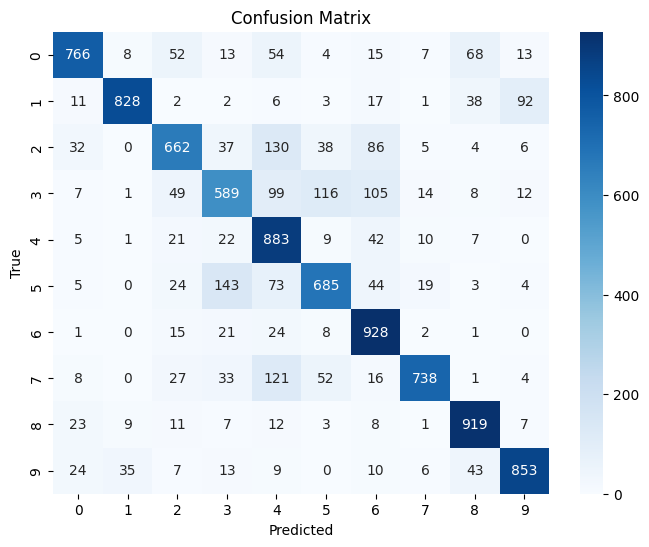

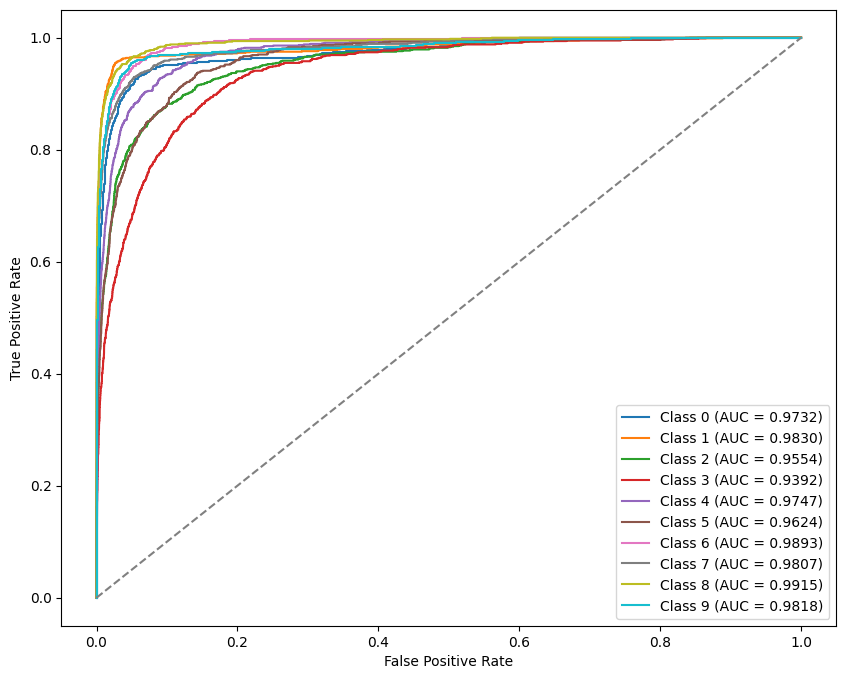

In [ ]:
def evaluate_model(model, dataset):
    y_true, y_pred, y_prob = [], [], []
    for images, labels in dataset:
        outputs = model(images)
        predictions = tf.argmax(outputs, axis=1)
        y_true.extend(labels.numpy())
        y_pred.extend(predictions.numpy())
        y_prob.extend(tf.nn.softmax(outputs).numpy())

    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    auc_score = roc_auc_score(tf.one_hot(y_true, output_size).numpy(), np.array(y_prob), average='macro', multi_class='ovr')

    print(f"Test Metrics -> Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {auc_score:.4f}")

    plt.figure(figsize=(8, 6))
    conf_matrix = confusion_matrix(y_true, y_pred)
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    plt.figure(figsize=(10, 8))
    y_true_binarized = tf.one_hot(y_true, output_size).numpy()
    for i in range(output_size):
        fpr, tpr, _ = roc_curve(y_true_binarized[:, i], np.array(y_prob)[:, i])
        auc_i = roc_auc_score(y_true_binarized[:, i], np.array(y_prob)[:, i])
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc_i:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

print("CNN Evaluation:")
evaluate_model(cnn_model, test_dataset)

#MLP

In [ ]:
mlp_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(32, 32, 3)),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(output_size, activation='softmax')
])

mlp_model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

def train_model(model, dataset, epochs):
    return model.fit(dataset, epochs=epochs, callbacks=[scheduler])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
print("Training MLP...")
train_model(mlp_model, train_dataset, epochs=epochs_mlp)

Training MLP...
Epoch 1/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.2259 - loss: 2.5658 - learning_rate: 1.0000e-04
Epoch 2/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.3120 - loss: 2.0536 - learning_rate: 1.0000e-04
Epoch 3/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.3417 - loss: 1.9205 - learning_rate: 1.0000e-04
Epoch 4/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.3606 - loss: 1.8518 - learning_rate: 1.0000e-04
Epoch 5/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.3817 - loss: 1.7752 - learning_rate: 1.0000e-04
Epoch 6/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.3935 - loss: 1.7314 - learning_rate: 1.0000e-04
Epoch 7/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.4063 - loss: 1.6769 - learning_rate: 1.0000e-04
Epoch 8/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.4163 - loss: 1.6440 - learning_rate: 1.0000e-04
Epoch 9/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accura

MLP Evaluation:
Test Metrics -> Accuracy: 0.5871, Precision: 0.5826, Recall: 0.5871, F1: 0.5832, AUC: 0.9169


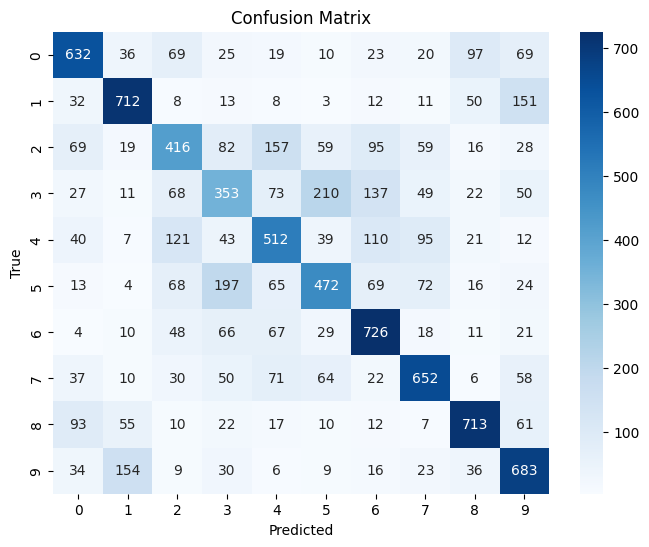

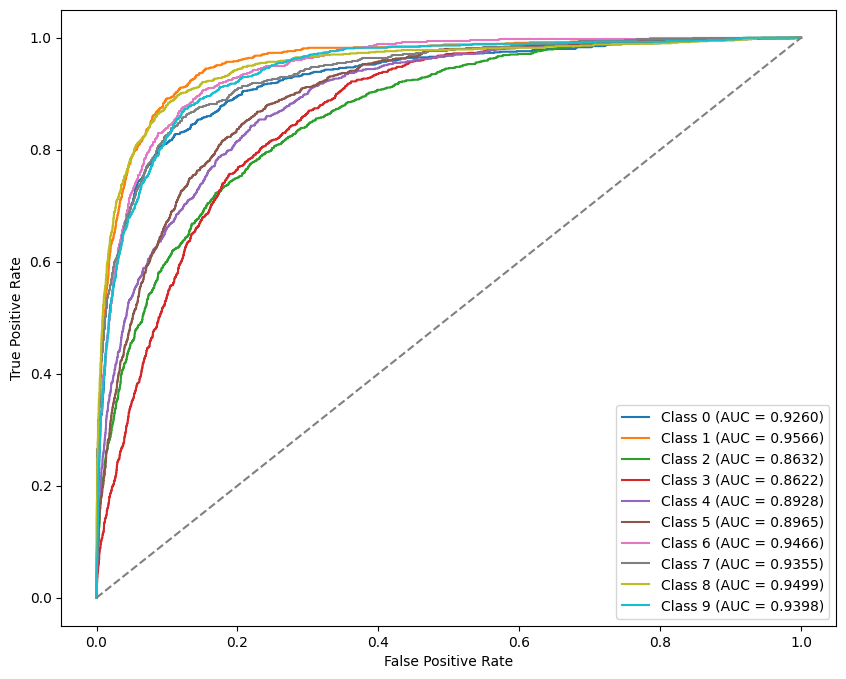

In [ ]:
def evaluate_model(model, dataset):
    y_true, y_pred, y_prob = [], [], []
    for images, labels in dataset:
        outputs = model(images)
        predictions = tf.argmax(outputs, axis=1)
        y_true.extend(labels.numpy())
        y_pred.extend(predictions.numpy())
        y_prob.extend(tf.nn.softmax(outputs).numpy())

    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    auc_score = roc_auc_score(tf.one_hot(y_true, output_size).numpy(), np.array(y_prob), average='macro', multi_class='ovr')

    print(f"Test Metrics -> Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {auc_score:.4f}")

    plt.figure(figsize=(8, 6))
    conf_matrix = confusion_matrix(y_true, y_pred)
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    plt.figure(figsize=(10, 8))
    y_true_binarized = tf.one_hot(y_true, output_size).numpy()
    for i in range(output_size):
        fpr, tpr, _ = roc_curve(y_true_binarized[:, i], np.array(y_prob)[:, i])
        auc_i = roc_auc_score(y_true_binarized[:, i], np.array(y_prob)[:, i])
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc_i:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

print("MLP Evaluation:")
evaluate_model(mlp_model, test_dataset)
